# Premières fonctionnalités d'Atom

## Trace

In [57]:
from atom import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

On créé un marché avec deux assets. Chacun des deux traders possède initialement 50 actions chez Apple et 40 chez Microsoft. Quand le marché est créé sans aucun paramètre, la trace est affichée.

In [58]:
#out = open('/dev/null', 'w')

m = Market()
m.add_asset(OrderBook('Apple'))
m.add_asset(OrderBook('Microsoft'))

for i in range(2):
    t = ZITTrader(['Apple','Microsoft'], [50, 40])
    m.add_trader(t)
for i in range(5):
    m.run_once()

Order;Apple;ZIT 144;BID;18;89;5
Order;Apple;ZIT 143;ASK;64;19;4
Tick;1
Order;Microsoft;ZIT 143;ASK;94;33;5
Order;Microsoft;ZIT 144;ASK;62;40;2
Tick;2
Order;Apple;ZIT 143;ASK;28;25;5
Order;Apple;ZIT 144;ASK;72;20;1
Tick;3
Order;Apple;ZIT 144;ASK;13;13;3
Price;Apple;ZIT 144;ZIT 144;18;13
Agent;ZIT 144;0;Apple;50
Order;Microsoft;ZIT 143;ASK;22;1;3
Tick;4;Apple;18
Order;Microsoft;ZIT 143;BID;22;38;3
Price;Microsoft;ZIT 143;ZIT 143;22;1
Agent;ZIT 143;0;Microsoft;40
Order;Apple;ZIT 144;ASK;17;25;1
Price;Apple;ZIT 144;ZIT 144;18;25
Agent;ZIT 144;0;Apple;50
Tick;5;Apple;18
Tick;5;Microsoft;22


## Écriture de la trace dans un fichier puis traitement des données

On peut faire la même chose en précisant dans quel fichier la trace doit être écrite...

In [59]:
out = open('trace.dat', 'w')

m = Market(out)
m.add_asset(OrderBook('Apple'))
m.add_asset(OrderBook('Microsoft'))

for i in range(10):
    t = ZITTrader(['Apple','Microsoft'], [100, 100])
    m.add_trader(t)
for i in range(1000):
    m.run_once()

out.close() # Remarque : Avec Jupyter, il est IMPÉRATIF de penser à fermer le fichier...

### Affichage des prix

Cela permet de récupérer les données, et par exemple, d'afficher les prix tick par tick...

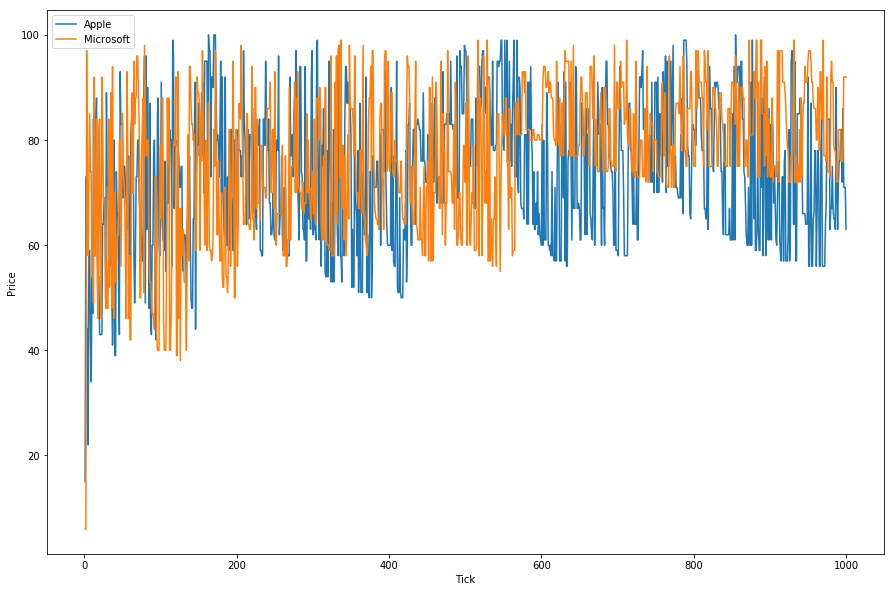

In [60]:
Prices = process_prices_per_tick('trace.dat')
# process_prices_per_tick prend un nom de fichier, le lit, et retourne un dictionnaire dont les clés sont les assets
# et les valeurs un tuple de listes : la première contient les différents tick et la second, le dernier prix prit par 
# l'asset à chaque tick
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.show()

... ou ce qui permet d'afficher la séquence des prix pour un asset donné.

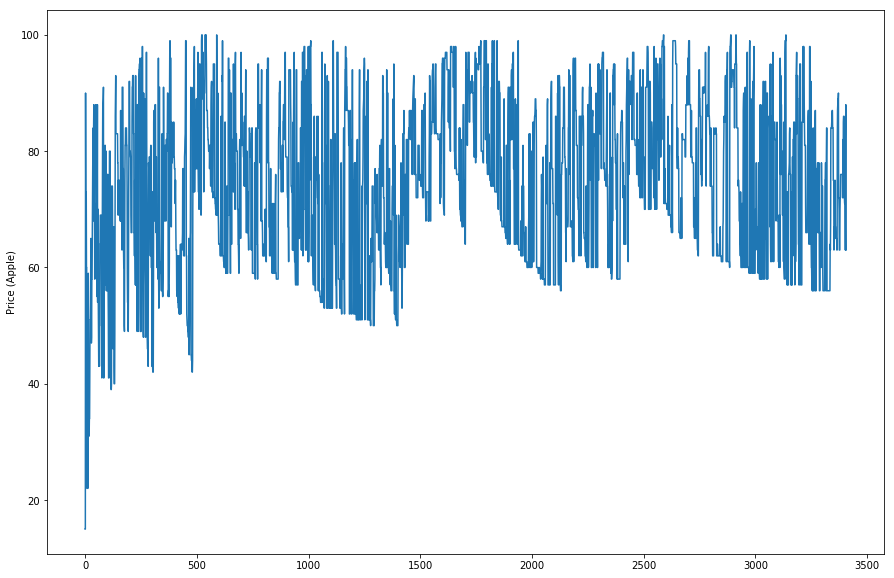

In [61]:
asset = 'Apple'
Prices = process_prices('trace.dat', asset)
# process_prices prend un nom de fichier et le nom d'un asset, et retourne l'ensemble des prix prit par cet asset dans
# la trace écrite dans le fichier
plt.plot(Prices, '-')
plt.ylabel('Price ('+asset+')')
plt.show()

### Affichage des rentabilités

On peut aussi afficher la séquence des rentabilités...

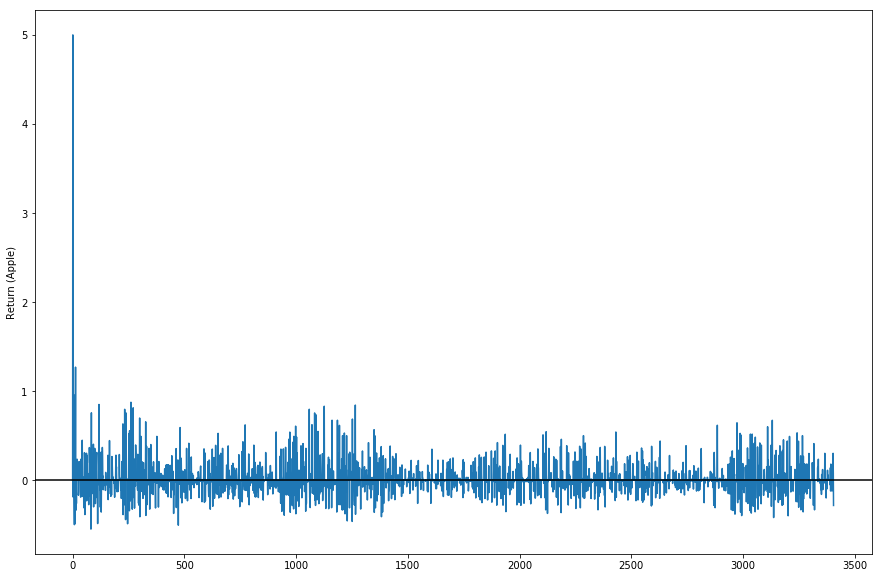

In [62]:
Prices = np.array(process_prices('trace.dat', asset))
Returns = (Prices[1:]-Prices[:-1])/Prices[:-1]
plt.plot(Returns, '-')
sigma = np.sqrt(np.mean((Returns-np.mean(Returns))**2))
plt.axhline(0, color='k')
plt.ylabel('Return ('+asset+')')
plt.show()

... ou affichier l'histogramme des rentabilités.

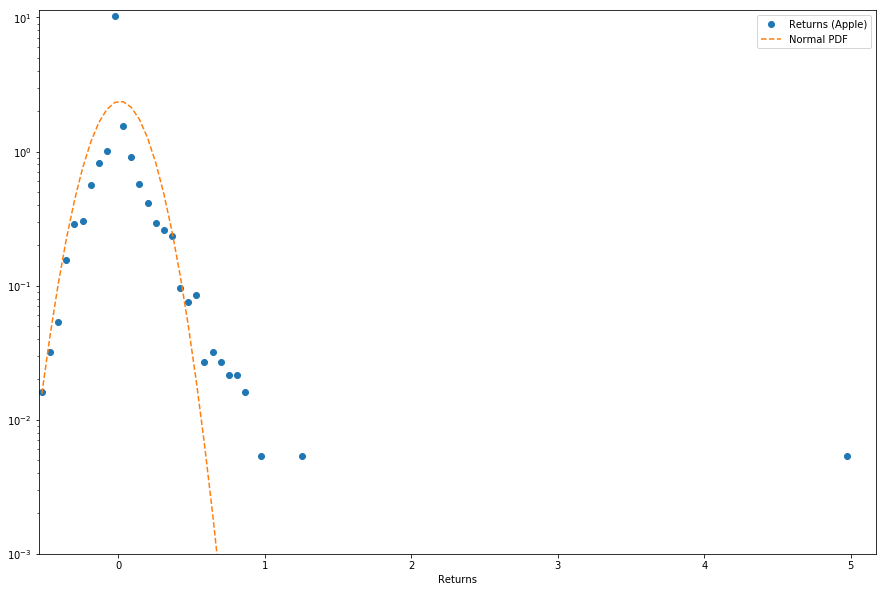

In [63]:
R, D, N = process_returns_hist('trace.dat', asset, 100)
# process_returns_hist prend un fichier, un asset et un nombre de points, et retourne un triplet (R, D, N) avec
# R les rentabilités, D leur densité, et N leur densité si la distribution de ces rentabilités suivait une loi normale
# de même espérance et écart-type
plt.semilogy(R, D, 'o', label='Returns ('+asset+')')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
plt.axis([min(R)*1.04, max(R)*1.04, 10**-3, max(D)*1.1])
plt.show()

## Problème avec les ZIT ?

Initialement, les ZIT tiraient leur ordre aléatoirement, indépendamment de la quantité d'actions qu'ils avaient : 
> def place_order(self, market):
>    return LimitOrder(random.choice(self.available_assets), self, random.choice(['ASK', 'BID']), random.randint(1, 100), random.randint(1, 100))

J'ai renommé ces ZIT en ZITTraderWithNegQty, puisqu'ils peuvent avoir une quantité négative d'asset. Avec ces ZIT, quand on trace l'histogramme des rentabilités, on observe que la densité pour les retours négatifs se situe sous la gausienne, ce qui n'est pas normal.

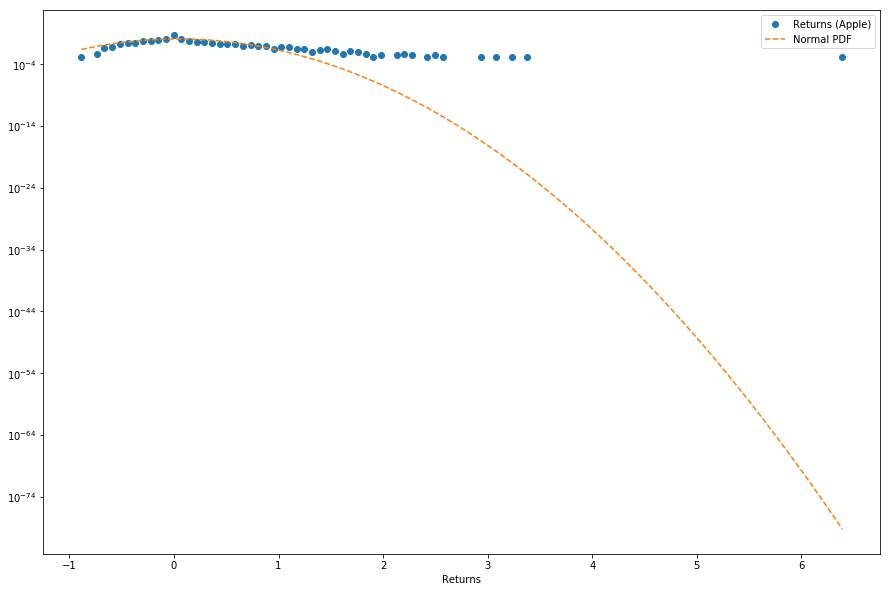

In [64]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
for i in range(10):
    t = ZITTraderWithNegQty(['Apple']) # ZITTraderWithNegQty
    m.add_trader(t)
for i in range(1000):
    m.run_once()
out.close()

R, D, N = process_returns_hist('trace.dat', asset, 100)
plt.semilogy(R, D, 'o', label='Returns ('+asset+')')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.legend(loc='best')
plt.show()

On n'observe pas ce phénomène avec les ZIT qui ne peuvent pas avoir de quantité d'actions négative :

In [69]:
out = open('trace.dat', 'w')
m = Market(out)
m.add_asset(OrderBook('Apple'))
for i in range(10):
    t = ZITTrader(['Apple'], [100, 100]) # ZITTrader
    m.add_trader(t)
for i in range(1000):
    m.run_once()
out.close()

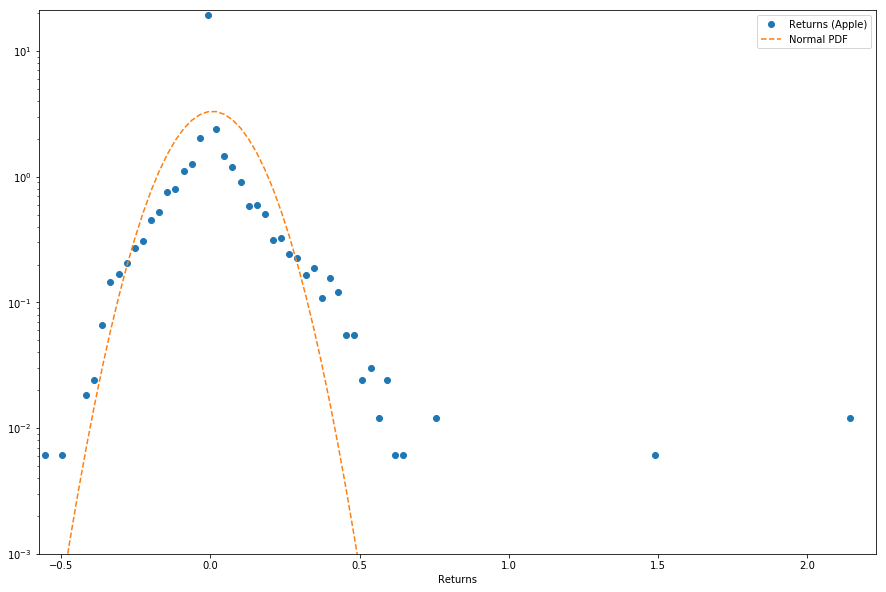

In [66]:
R, D, N = process_returns_hist('trace.dat', asset, 100)
plt.semilogy(R, D, 'o', label='Returns ('+asset+')')
plt.semilogy(R, N, '--', label='Normal PDF')
plt.xlabel('Returns')
plt.axis([min(R)*1.04, max(R)*1.04, 10**-3, max(D)*1.1])
plt.legend(loc='best')
plt.show()

Le problème est qu'avec ces ZIT, les prix (cf la sous-section précédente) ne descendent pas en dessous d'un certain seuil (50 ou 60) après quelques tours...

En fait, on observe un phénomène assez étrange : selon le nombre d'actions avec lequel on initialise les traders, la courbe de prix a une allure tout à faire différente.
On va prendre trois assets : A, B et C. Tous les ZIT auront initialement 10 actions de A, 500 de B et 10000 de C.

In [70]:
out = open('trace.dat', 'w')

m = Market(out)
m.add_asset(OrderBook('A'))
m.add_asset(OrderBook('B'))
m.add_asset(OrderBook('C'))

for i in range(10):
    t = ZITTrader(['A','B', 'C'], [10, 500, 10000])
    m.add_trader(t)
for i in range(10000):
    m.run_once()

out.close() # Remarque : Avec Jupyter, il est IMPÉRATIF de penser à fermer le fichier...

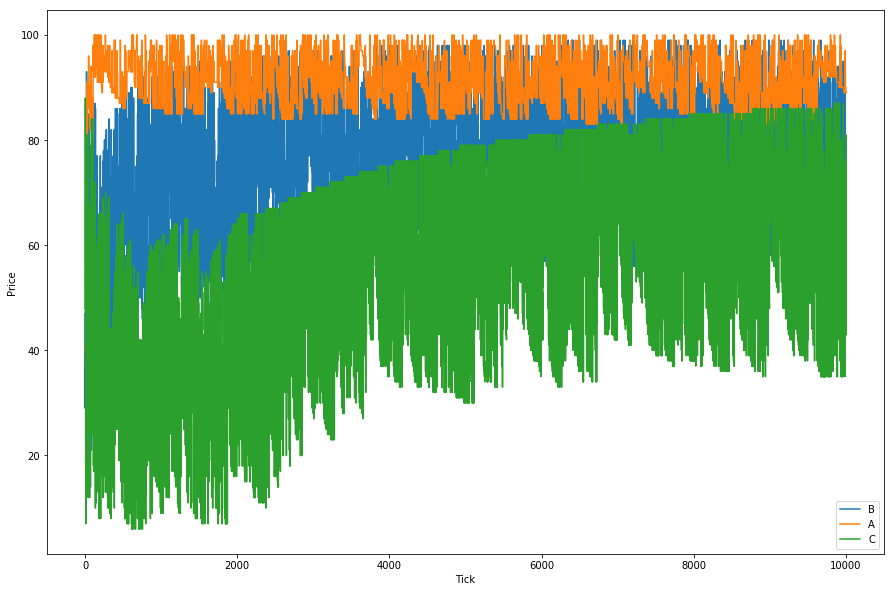

In [71]:
Prices = process_prices_per_tick('trace.dat')
# process_prices_per_tick prend un nom de fichier, le lit, et retourne un dictionnaire dont les clés sont les assets
# et les valeurs un tuple de listes : la première contient les différents tick et la second, le dernier prix prit par 
# l'asset à chaque tick
for asset in Prices.keys():
    plt.plot(Prices[asset][0], Prices[asset][1], '-', label=asset)
plt.legend(loc='best')
plt.xlabel('Tick')
plt.ylabel('Price')
plt.show()

Toutes les courbes sont "globalement croissante", et cette croissance et d'autant plus lente que le nombre d'actions dont disposent les agents initialement est élevé.

### En fait, les time_to_live, c'était une bonne idée

Ce phénomène s'explique parce qu'en forçant les ZIT à avoir une quantité d'actions positive (je l'ai implémenté de la façon suivante : 
* quand un agent doit placer un ordre, pour chaque asset, on calcule le nombre d'actions vendable, càd le nombre d'actions dont il dispose pour cet asset auquel on retranche toutes les actions qui sont concernées par un ordre BID de la part de cet agent dans l'orderbook de l'asset.
* si l'agent n'a aucun asset avec une quanté d'actions vendables non nulle, il place un BID aléatoire
* sinon, il choisi aléatoirement entre un ASK (qui sera alors tiré parmi ses assets qu'il peut vendre) et un BID aléatoire

Le problème est que, comme les prix de chaque ordre est choisi aléatoirement entre 1 et 100, l'agent va, de temps en temps, donner des ordres ASK à des prix très élevés, qui vont donc prendre du temps à matcher. Les ASK avec des prix "raisonnables" vont matcher des BID, et petit à petit, il ne va rester plus que des ASK avec un prix très élevé dans l'orderbook. Plus la quantité initiale d'actions dont dispose l'agent est élevée, plus ce phénomène de hausse des prix va prendre du temps à arriver, puisque l'agent va moins rapidement se retrouver dans une situation dans laquelle il ne peut plus vendre.
La solution à ce problème est donc simple : remettre un time_to_live à chaque ordre pour éviter que tous les agents se retrouvent avec aucune action vendable avec toutes les actions dont il dispose engagées dans un ASK à prix très élevé. On devrait alors voir disparaître ce phénomène de croissance globale (puis stagnation) des prix au cours du temps.